# 1 準備

In [1]:
!nvidia-smi

Wed Jun 15 10:37:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# データ作成に使用するライブラリ
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

In [3]:
batch_size = 100
n_channel = 100
n_epoch = 10

In [4]:
# データ作成に使用するライブラリ
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

root = './data'
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
dataloader = DataLoader(mnist_train,batch_size=batch_size,shuffle=True)

In [5]:
# gpuの指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2 モデル

In [6]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(n_channel, 512, 3, 1, 0),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ), 
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(512, 256, 3, 2, 0),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            'layer3': nn.Sequential(
                nn.ConvTranspose2d(128, 1, 4, 2, 1),
                nn.Tanh()
            )
        })

    def forward(self, z):

        for layer in self.layers.values(): 
            z = layer(z)
        return z


In [7]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(1, 128, 4, 2, 1),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer1': nn.Sequential(
                nn.Conv2d(128, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer2': nn.Sequential(
                nn.Conv2d(256, 512, 3, 2, 0),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer3': nn.Sequential(
                nn.Conv2d(512, 1, 3, 1, 0),
                nn.Sigmoid()
            )    
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x.squeeze()

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [9]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

# 3 モデルの学習

In [10]:
G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

# 学習のループ
for epoch in range(n_epoch):

    for x, t in dataloader:

      # 前準備
      real_image = x.to(device) # 本物の画像データ
      noise = torch.randn(batch_size, n_channel, 1, 1, device=device) # ノイズ作成
      real_target = torch.full((batch_size,), 1., device=device) # 本物ラベル
      fake_target = torch.full((batch_size,), 0., device=device) # 偽物ラベル
      
      # discriminatorの学習(本物画像の学習)
      discriminator.zero_grad() 
      y = discriminator(real_image)
      errD_real = criterion(y, real_target)
      D_x = y.mean().item()

      # discriminatorの学習(偽物画像の学習)
      fake_image = generator(noise)
      y = discriminator(fake_image.detach())
      errD_fake = criterion(y, fake_target)
      D_G_z1 = y.mean().item()

      # discriminatorの更新
      errD = errD_real + errD_fake
      errD.backward()
      optimizerD.step()

      # generatorの学習
      generator.zero_grad()
      y = discriminator(fake_image)
      errG = criterion(y, real_target)
      errG.backward()
      D_G_z2 = y.mean().item()
      optimizerG.step()

      # 損失関数のリスト作成
      D_losses.append(errD.item())
      G_losses.append(errG.item())
      D_x_list.append(D_x)
      D_G_z1_list.append(D_G_z1)
      D_G_z1_list.append(D_G_z2)
      
    print('Epoch:{}/{}, Loss_D: {:.3f}, Loss_G: {:.3f}, D(x): {:.3f}, D(G(z)): {:.3f}/{:.3f}'
    .format(epoch + 1, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Epoch:1/10, Loss_D: 0.951, Loss_G: 2.650, D(x): 0.805, D(G(z)): 0.459/0.093
Epoch:2/10, Loss_D: 1.192, Loss_G: 3.585, D(x): 0.956, D(G(z)): 0.635/0.037
Epoch:3/10, Loss_D: 0.686, Loss_G: 2.840, D(x): 0.846, D(G(z)): 0.358/0.079
Epoch:4/10, Loss_D: 0.688, Loss_G: 1.643, D(x): 0.628, D(G(z)): 0.136/0.240
Epoch:5/10, Loss_D: 0.662, Loss_G: 1.695, D(x): 0.665, D(G(z)): 0.161/0.247
Epoch:6/10, Loss_D: 0.923, Loss_G: 0.902, D(x): 0.513, D(G(z)): 0.119/0.479
Epoch:7/10, Loss_D: 0.726, Loss_G: 1.466, D(x): 0.567, D(G(z)): 0.057/0.312
Epoch:8/10, Loss_D: 0.516, Loss_G: 2.010, D(x): 0.762, D(G(z)): 0.169/0.184
Epoch:9/10, Loss_D: 0.505, Loss_G: 2.715, D(x): 0.719, D(G(z)): 0.114/0.097
Epoch:10/10, Loss_D: 0.570, Loss_G: 1.368, D(x): 0.657, D(G(z)): 0.091/0.331


# 4 画像の生成

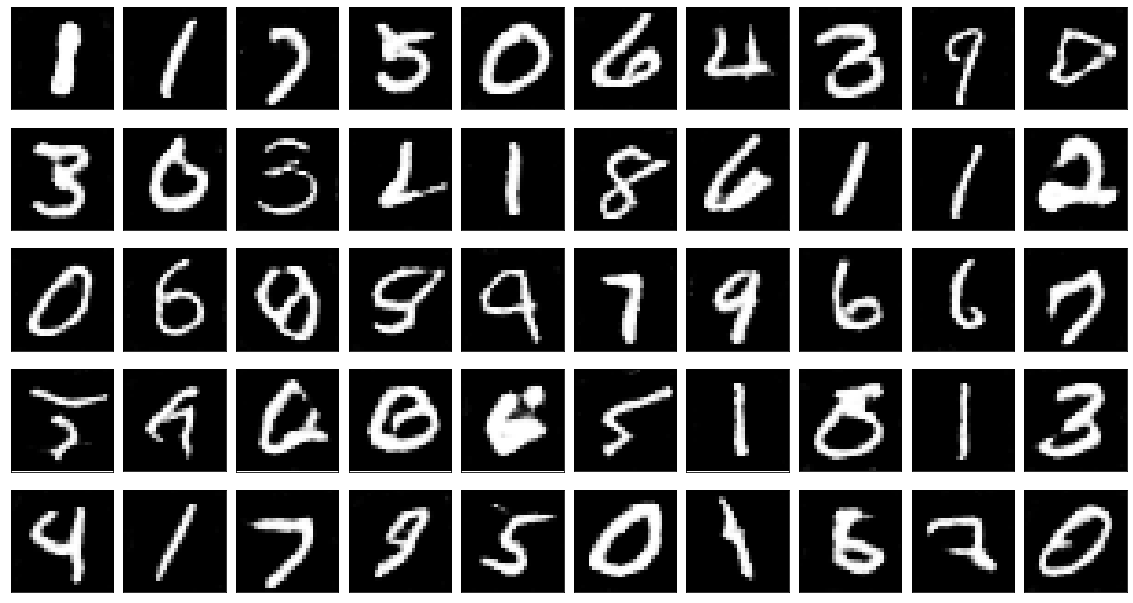

In [11]:
# fake_image作成
generator.eval
noise = torch.randn(50, n_channel, 1, 1, device=device)
y = generator(noise)

# fake_image可視化
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(y[i,].view(28,28).cpu().detach(), "gray")